In [45]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) 

In [46]:
from keras.datasets import boston_housing
from keras import models, layers
import numpy as np

In [47]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [48]:
print('Shape of train data', train_data.shape)
print('Shape of test data', test_data.shape)

Shape of train data (404, 13)
Shape of test data (102, 13)


In [49]:
mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [50]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

### Textbook - Case (1)

In [51]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold # :', i)
    val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[ : i*num_val_samples],
         train_data[(i+1)*num_val_samples : ]],
        axis = 0)

    partial_train_targets = np.concatenate(
        [train_targets[ : i*num_val_samples],
         train_targets[(i+1)*num_val_samples : ]],
        axis = 0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # : 0
processing fold # : 1
processing fold # : 2
processing fold # : 3


In [52]:
all_scores

[2.112868547439575, 2.5300331115722656, 2.8052823543548584, 2.3427658081054688]

In [53]:
np.mean(all_scores)

2.447737455368042

### Textbook - Case (2)

In [54]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold # :', i)
    val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[ : i*num_val_samples],
         train_data[(i+1)*num_val_samples : ]],
        axis = 0)

    partial_train_targets = np.concatenate(
        [train_targets[ : i*num_val_samples],
         train_targets[(i+1)*num_val_samples : ]],
        axis = 0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # : 0
processing fold # : 1
processing fold # : 2
processing fold # : 3


In [55]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [56]:
import matplotlib.pyplot as plt

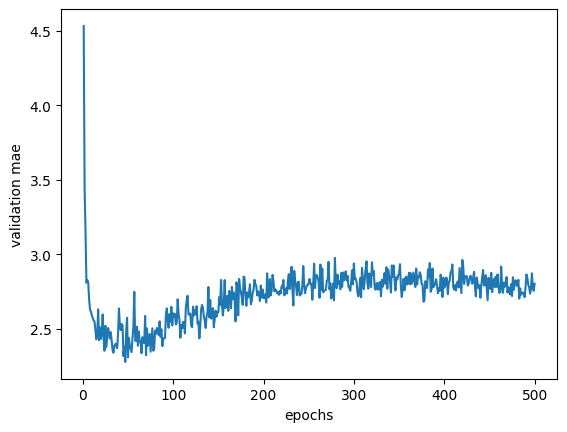

In [57]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('epochs')
plt.ylabel('validation mae')
plt.show()

In [58]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

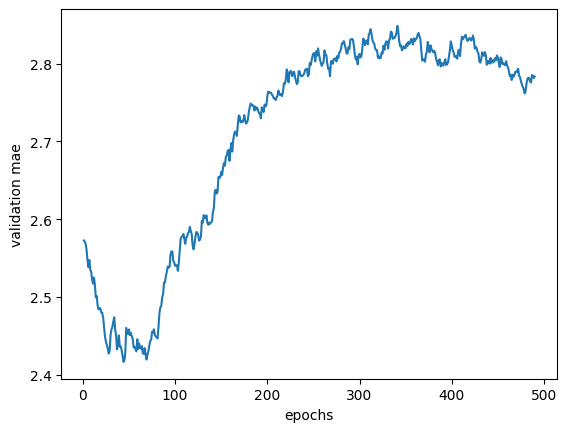

In [59]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('epochs')
plt.ylabel('validation mae')
plt.show()

### Textbook - Case (3)

In [60]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print('mse', test_mse_score)
print('mae', test_mae_score)

4/4 [==============================] - 0s 5ms/step - loss: 17.9598 - mae: 2.5391
mse 17.959789276123047
mae 2.539125442504883


### Additional Experiments (1) Regularizer

In [61]:
from keras import regularizers

def build_model_2():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],),
                                        kernel_regularizer=regularizers.l2(1e-1)))
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-1)))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [62]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('Fold being processed :', i)
    val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[ : i*num_val_samples],
         train_data[(i+1)*num_val_samples : ]],
        axis = 0)

    partial_train_targets = np.concatenate(
        [train_targets[ : i*num_val_samples],
         train_targets[(i+1)*num_val_samples : ]],
        axis = 0)
    
    model = build_model_2() ###
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Fold being processed : 0
Fold being processed : 1
Fold being processed : 2
Fold being processed : 3


In [63]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

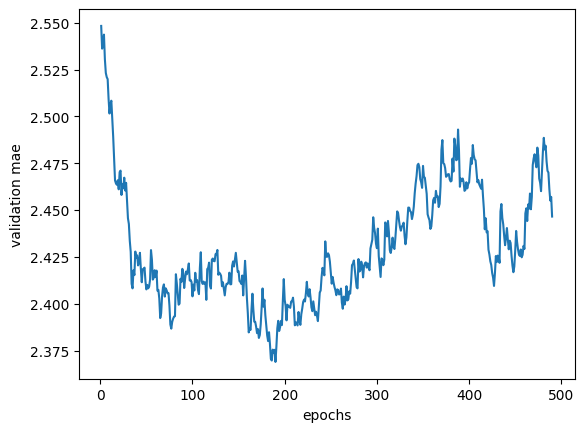

In [64]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('epochs')
plt.ylabel('validation mae')
plt.show()

In [65]:
model = build_model_2()
model.fit(train_data, train_targets, epochs=250, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print('mse', test_mse_score)
print('mae', test_mae_score)

4/4 [==============================] - 0s 1ms/step - loss: 18.9876 - mae: 2.6180
mse 18.98760414123535
mae 2.618021249771118


### Additional Experiments (2) Regularizer + Dropout

In [66]:
def build_model_3():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],),
                                        kernel_regularizer=regularizers.l2(1e-1)))
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-1)))
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [67]:
num_epochs = 100
all_mae_histories = []
for i in range(k):
    print('Fold being processed :', i)
    val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[ : i*num_val_samples],
         train_data[(i+1)*num_val_samples : ]],
        axis = 0)

    partial_train_targets = np.concatenate(
        [train_targets[ : i*num_val_samples],
         train_targets[(i+1)*num_val_samples : ]],
        axis = 0)
    
    model = build_model_3() ###
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Fold being processed : 0
Fold being processed : 1
Fold being processed : 2
Fold being processed : 3


In [68]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

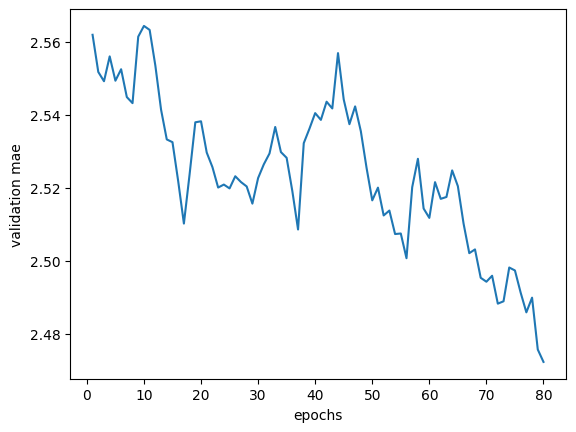

In [69]:
smooth_mae_history = smooth_curve(average_mae_history[20:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('epochs')
plt.ylabel('validation mae')
plt.show()

In [70]:
model = build_model_3()
model.fit(train_data, train_targets, epochs=480, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print('mse', test_mse_score)
print('mae', test_mae_score)

4/4 [==============================] - 0s 2ms/step - loss: 19.2600 - mae: 2.7776
mse 19.260034561157227
mae 2.777595043182373


### Additional Experiments (3)  Dropout.

In [71]:
def build_model_4():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],),))
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [72]:
num_epochs = 100
all_mae_histories = []
for i in range(k):
    print('Fold being processed :', i)
    val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[ : i*num_val_samples],
         train_data[(i+1)*num_val_samples : ]],
        axis = 0)

    partial_train_targets = np.concatenate(
        [train_targets[ : i*num_val_samples],
         train_targets[(i+1)*num_val_samples : ]],
        axis = 0)
    
    model = build_model_4() ###
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Fold being processed : 0
Fold being processed : 1
Fold being processed : 2
Fold being processed : 3


In [73]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

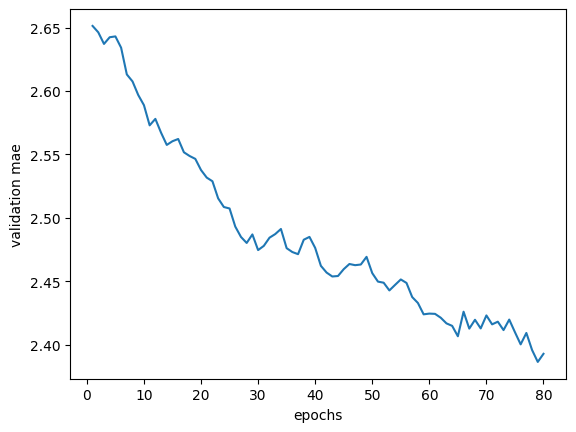

In [74]:
smooth_mae_history = smooth_curve(average_mae_history[20:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('epochs')
plt.ylabel('validation mae')
plt.show()

In [75]:
model = build_model_4()
model.fit(train_data, train_targets, epochs=300, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print('mse', test_mse_score)
print('mae', test_mae_score)

4/4 [==============================] - 0s 2ms/step - loss: 17.1057 - mae: 2.7272
mse 17.105669021606445
mae 2.7271955013275146


### Additional Experiments (4) Activation Function  -> leaky relu

In [76]:
import keras.layers as kl

def build_model_5():
    model = models.Sequential()
    model.add(layers.Dense(64, activation=kl.LeakyReLU(alpha=0.3), input_shape=(train_data.shape[1],),))
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(64, activation=kl.LeakyReLU(alpha=0.3)))
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [77]:
num_epochs = 100
all_mae_histories = []
for i in range(k):
    print('Fold being processed :', i)
    val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[ : i*num_val_samples],
         train_data[(i+1)*num_val_samples : ]],
        axis = 0)

    partial_train_targets = np.concatenate(
        [train_targets[ : i*num_val_samples],
         train_targets[(i+1)*num_val_samples : ]],
        axis = 0)
    
    model = build_model_5() ###
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Fold being processed : 0
Fold being processed : 1
Fold being processed : 2
Fold being processed : 3


In [78]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

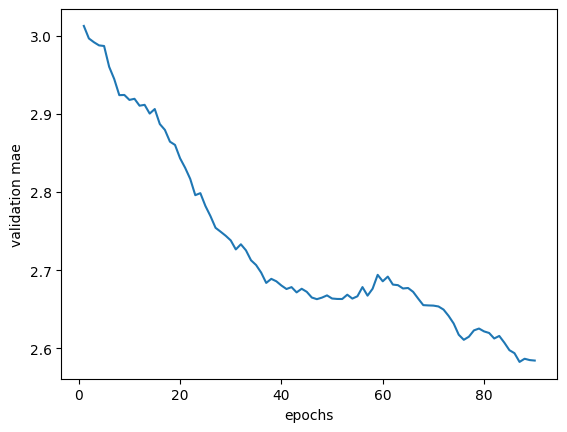

In [79]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('epochs')
plt.ylabel('validation mae')
plt.show()

In [80]:
model = build_model_5()
model.fit(train_data, train_targets, epochs=400, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print('mse', test_mse_score)
print('mae', test_mae_score)

4/4 [==============================] - 0s 2ms/step - loss: 18.2267 - mae: 2.7401
mse 18.226747512817383
mae 2.740144729614258
